In [2]:
%matplotlib inline
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image

# --- ATLAS style ---
ROOT.gROOT.LoadMacro("/home/kalelc/research/atlasstyle/AtlasStyle.C")
ROOT.gROOT.LoadMacro("/home/kalelc/research/atlasstyle/AtlasUtils.C")
ROOT.gROOT.LoadMacro("/home/kalelc/research/atlasstyle/AtlasLabels.C")
ROOT.SetAtlasStyle()

ROOT.EnableImplicitMT()

# --- Load Delphes ---
delphes_dir = "/home/kalelc/research/Delphes-3.5.0/"
status = ROOT.gSystem.Load(delphes_dir + "libDelphes.so")
if status != 0:
    raise RuntimeError("Error: Could not load libDelphes.so")
print("libDelphes.so loaded successfully!")

# Input ROOT file
fdisplaced = delphes_dir + "displacedPhoton/displaced_half_dark_events.root"
fprompt = delphes_dir + "displacedPhoton/prompt_half_dark_events.root"
df_displaced = ROOT.RDataFrame("Delphes", fdisplaced)
df_prompt = ROOT.RDataFrame("Delphes", fprompt)


Applying ATLAS style settings...

libDelphes.so loaded successfully!


In [3]:
def create_missingET_dataframe(root_file_path):
    # Load the ROOT file into an RDataFrame
    rdf = ROOT.RDataFrame("Delphes", root_file_path)
    
    # Convert the specified properties to a dictionary of numpy arrays
    missingET_dict = rdf.AsNumpy([
        "Event.Number",
        "MissingET.MET",
        "MissingET.Phi",
        "GenMissingET.MET",
        "GenMissingET.Phi",
    ])
    
    # Flatten event numbers (scalars, not 1-element arrays)
    event_numbers = [arr[0] for arr in missingET_dict["Event.Number"]]
    
    # Build the DataFrame
    missingET_df = pd.DataFrame({
        "EventNumber": event_numbers,
        "MissingET_MET": missingET_dict["MissingET.MET"],
        "MissingET_Phi": missingET_dict["MissingET.Phi"],
        "GenMissingET_MET": missingET_dict["GenMissingET.MET"],
        "GenMissingET_Phi": missingET_dict["GenMissingET.Phi"],
    })
    
    # Explode so each entry gets its own row
    missingET_df = missingET_df.explode(
        ["MissingET_MET", "MissingET_Phi",
         "GenMissingET_MET", "GenMissingET_Phi"], 
        ignore_index=True
    )

    # Sort by EventNumber and reset the index
    missingET_df = missingET_df.sort_values(by="EventNumber").reset_index(drop=True)
    
    return missingET_df

In [4]:
displaced_missingET_df = create_missingET_dataframe(fdisplaced)
prompt_missingET_df = create_missingET_dataframe(fprompt)
displaced_missingET_df

,EventNumber,MissingET_MET,MissingET_Phi,GenMissingET_MET,GenMissingET_Phi
0,0,26.017002,-1.24223,39.143513,-1.479393
1,1,38.249065,2.871689,23.68718,-1.932783
2,2,50.321133,-0.111179,95.386909,-0.467594
3,3,55.87775,2.176007,78.944168,2.877817
4,4,52.695034,-0.151504,17.324291,-0.014991
...,...,...,...,...,...
5995,5995,47.308689,2.21096,50.332729,2.287209
5996,5996,21.292564,0.590059,63.469204,-1.802907
5997,5997,38.789661,0.15284,69.64875,1.197068
5998,5998,37.51313,0.5588,56.057983,-0.671687


In [6]:
difference_missingET_df = pd.DataFrame({
    "EventNumber": displaced_missingET_df["EventNumber"],
    "GenMET": displaced_missingET_df["GenMissingET_MET"],
    "GenPhi": displaced_missingET_df["GenMissingET_Phi"],
    "GenMatch": displaced_missingET_df["GenMissingET_MET"] == prompt_missingET_df["GenMissingET_MET"],
    "delta_MET": displaced_missingET_df["MissingET_MET"] - prompt_missingET_df["MissingET_MET"],
    "delta_Phi": displaced_missingET_df["MissingET_Phi"] - prompt_missingET_df["MissingET_Phi"],
})
difference_missingET_df

,EventNumber,GenMET,GenPhi,GenMatch,delta_MET,delta_Phi
0,0,39.143513,-1.479393,True,-12.176193,0.093527
1,1,23.68718,-1.932783,True,16.678061,5.066405
2,2,95.386909,-0.467594,True,-40.35445,0.306994
3,3,78.944168,2.877817,True,-26.312595,-0.623985
4,4,17.324291,-0.014991,True,37.231791,0.022109
...,...,...,...,...,...,...
5995,5995,50.332729,2.287209,True,9.228359,5.010156
5996,5996,63.469204,-1.802907,True,-20.733242,3.278921
5997,5997,69.64875,1.197068,True,-10.216591,-0.608432
5998,5998,56.057983,-0.671687,True,2.81065,0.516661


Text(0, 0.5, 'GenPhi')

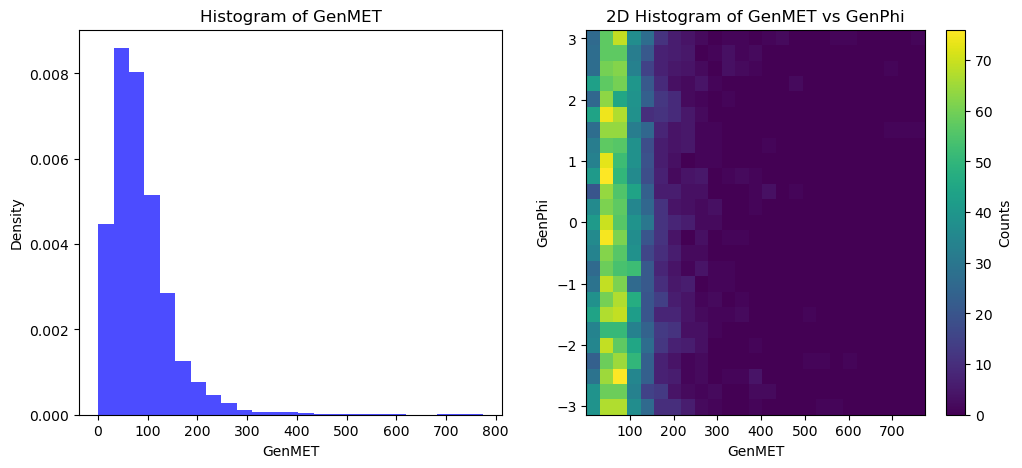

In [7]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 5))
# First subplot: Histogram of GenMET
ax1.hist(difference_missingET_df["GenMET"].astype(float), bins=25, color='blue', alpha=0.7, density=True)
ax1.set_title("Histogram of GenMET")
ax1.set_xlabel("GenMET")
ax1.set_ylabel("Density")

# Second subplot: 2D histogram of GenMET vs GenPhi
h = ax2.hist2d(
    difference_missingET_df["GenMET"].astype(float),
    difference_missingET_df["GenPhi"].astype(float),
    bins=(25, 25)
)
fig.colorbar(h[3], ax=ax2, label="Counts")
ax2.set_title("2D Histogram of GenMET vs GenPhi")
ax2.set_xlabel("GenMET")
ax2.set_ylabel("GenPhi")

Text(0, 0.5, 'delta_Phi')

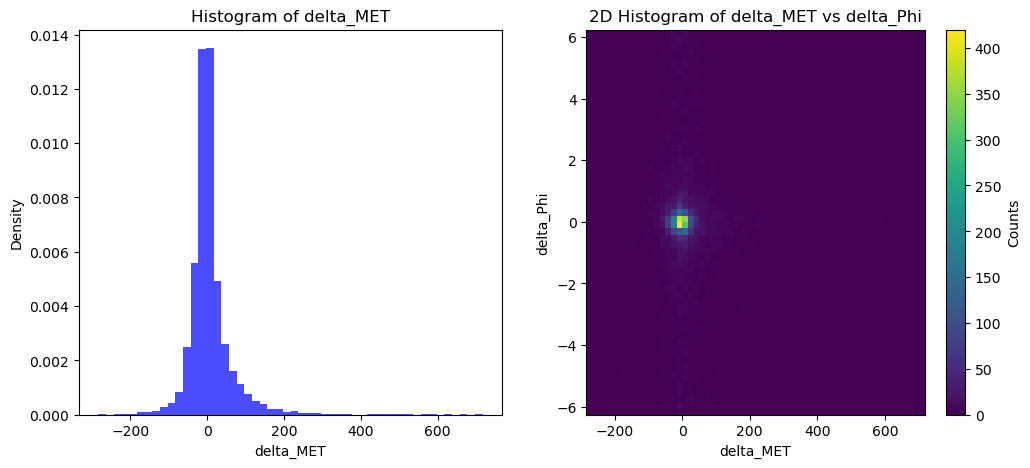

In [9]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 5))

# First subplot: Histogram of delta_MET
ax1.hist(difference_missingET_df["delta_MET"].astype(float), bins=50, color='blue', alpha=0.7, density=True)
ax1.set_title("Histogram of delta_MET")
ax1.set_xlabel("delta_MET")
ax1.set_ylabel("Density")

# Second subplot: 2D histogram of delta_MET vs delta_Phi
h = ax2.hist2d(
    difference_missingET_df["delta_MET"].astype(float),
    difference_missingET_df["delta_Phi"].astype(float),
    bins=(60, 60)
)
fig.colorbar(h[3], ax=ax2, label="Counts")
# ax2.set_xlim(-1.5, 1.5)
# ax2.set_ylim(-1.5, 1.5)
ax2.set_title("2D Histogram of delta_MET vs delta_Phi")
ax2.set_xlabel("delta_MET")
ax2.set_ylabel("delta_Phi")